# Forecasting Nino indices using regression

- https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni 
- Adapted from this workflow: https://github.com/NCAR/ML_workshop2023/blob/main/tutorials/Day1_simple_regression/Linear_Models.ipynb

### Input Data Access
- Nino 3.4 prediction from global SSTs
- Dataset description
- Nino3.4 index time series from the NCAR Climate Gateway and Monthly SST Anomalies from the Cobe V2. dataset
- Nino3.4 is a time series of sea surface temperature [SST] anomalies averaged in the tropical pacific (lat [5N-5S], lon [170W-120W]). The index typically consists of a 5- month running mean SST field

-The Cobe V2. data set is a 1.0 degree latitude x 1.0 degree longitude global grid (180x360) resolution sea surface tempearture field which spans latitude: 89.5N - 89.5S, and longitude: 0.5E - 359.5E. is analysis, a daily SST field is constructed as a sum of a trend, interannual variations, and daily changes, using in situ SST and sea ice concentration observations.
- This notebook illustrates how to ......
- This data is open access and is accessed via OSDF

In [1]:
#Imports
import intake
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import re
import matplotlib.pyplot as plt
import os 
import pandas as pd
#
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import netCDF4
import fsspec

In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 
# import cf_units as cf

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [5]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")

In [6]:
lustre_scratch   = "/lustre/desc1/scratch/harshah"
ml_osdf_path= '/ncar/gdex/d850001/'

In [7]:
# # Posix paths for testing
# ml_posix_path = '/gdex/data/d850001'

In [8]:
osdf_fs = OSDFFileSystem()

### Useful loading functions
- Use palicanfs to load input data

In [9]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices(folder_path):
    """
    Reads the ENSO data file from the specified folder and outputs a pandas Series of ENSO values.

    Parameters
    ----------
    folder_path : str
        Path to the folder containing the 'nino34.long.anom.data.txt' file.

    Returns
    -------
    pd.Series
        Monthly ENSO values starting from 1870-01-01.
    """
    file_name = 'nino34.long.anom.data.txt'
    file_path = os.path.join(folder_path, file_name)
    print(file_path)

    # Use the osdf protocol to access the file
    osdf_fs = OSDFFileSystem()   
    
    # if not os.path.exists(file_path):
    #     raise FileNotFoundError(f"The file '{file_name}' was not found in the folder '{folder_path}'.")
    
    with osdf_fs.open(file_path, 'rb') as f:
        enso_vals = []
        for line in f:
            try:
                yearly_enso_vals = map(float, line.split()[1:])
                enso_vals.extend(yearly_enso_vals)
            except ValueError:
                # Skip lines that cannot be parsed as ENSO data
                continue
    
    enso_vals = pd.Series(enso_vals)
    enso_vals.index = pd.date_range('1870-01-01', freq='MS', periods=len(enso_vals))
    enso_vals.index = pd.to_datetime(enso_vals.index)
    
    return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time,folder_path, 
                                    use_pca=False, n_components=32):
    """
    inputs
    ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date 
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

    outputs
    -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

    """
    file_name = 'sst.mon.mean.trefadj.anom.1880to2018.nc'
    
    # For an osdf protocol file
    osdf_fs = OSDFFileSystem()
    
    file_path = os.path.join(folder_path, file_name)
    print(file_path)
    
    #########################
    ds = xr.open_dataset(osdf_fs.open(file_path,mode='rb'), engine= 'h5netcdf')
    
    # ds = xr.open_dataset(file_name)
    sst = ds['sst'].sel(time=slice(start_date, end_date))
    num_time_steps = sst.shape[0]
  
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.values.reshape(num_time_steps, -1)
    sst[np.isnan(sst)] = 0

    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
        pca = sklearn.decomposition.PCA(n_components=n_components)
        pca.fit(sst)
        X = pca.transform(sst)
    else:
        X = sst

    start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
    end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
    y = load_enso_indices(ml_osdf_path)[slice(start_date_plus_lead, 
                                end_date_plus_lead)]

    ds.close()
    return X, y

def plot_nino_time_series(y, predictions, title):
    """
    inputs
    ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

    outputs
    -------
    None.  Displays the plot
    """
    predictions = pd.Series(predictions, index=y.index)
    predictions = predictions.sort_index()
    y = y.sort_index()

    plt.plot(y, label='Ground Truth',color='xkcd:teal')
    plt.plot(predictions, '--', label='ML Predictions',color='xkcd:purple')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel('Nino3.4 Index')
    plt.xlabel('Date')
    plt.show()
    plt.close()

## Create a PBS cluster

In [10]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = lustre_scratch+'/dask/spill',
    log_directory = lustre_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35107 instead
  warnings.warn(


In [11]:
cluster.scale(3)

In [12]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/35107/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:34749,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/35107/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load CESM LENS2 temperature data

/ncar/gdex/d850001/sst.mon.mean.trefadj.anom.1880to2018.nc
/ncar/gdex/d850001/nino34.long.anom.data.txt


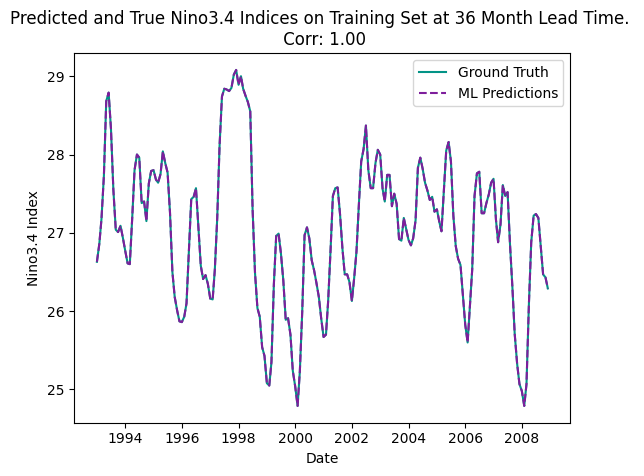

In [13]:
%matplotlib inline

#Load in the predictors
X, y = assemble_predictors_predictands('1990-01-01','2005-12-31', 36, ml_osdf_path)

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Corr: {:.2f}'.format(corr))

## This is totally unrealisitic !! Why? Let us investigate

In [ ]:
cluster.close()